In [20]:
import nltk
import pandas
import sklearn 
import torch
import seaborn
import matplotlib.pyplot as plt

In [ ]:
# downloading corpus + tagset

nltk.download('brown')
nltk.download('universal_tagset')

In [22]:
# sentences

sentences = nltk.corpus.brown.tagged_sents(tagset = 'universal')

In [23]:
print(sentences)

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [24]:
# test-train split

training_sentences, testing_sentences = sklearn.model_selection.train_test_split(sentences, test_size = 0.01, random_state = 42)

In [25]:
# isolating tagged words

training_words_tagged = [word for sentence in training_sentences for word in sentence]
testing_words_tagged = [word for sentence in testing_sentences for word in sentence]

print(len(training_words_tagged))
print(len(testing_words_tagged))


1150045
11147


In [26]:
# listing all the training words and tags in order

training_taglist = [tag for word, tag in training_words_tagged]
training_wordlist = [word for word, tag in training_words_tagged]

# listing words and tags without duplication

unique_taglist = list(set(training_taglist))
unique_wordlist = list(set(training_wordlist))

print(len(unique_taglist), len(unique_wordlist))
print(len(training_taglist))
print(len(training_wordlist))

print(unique_taglist)

12 55832
1150045
1150045
['X', 'CONJ', 'NUM', 'VERB', 'ADP', 'DET', '.', 'PRT', 'NOUN', 'ADJ', 'ADV', 'PRON']


In [27]:
# emission probability
# this is the probability of a word given a tag

def ep_word_tag(word, tag):
    
    # number of pairs containing the tag given

    pairlist = [tup for tup in training_words_tagged if tup[1] == tag]
    len_pairlist = len(pairlist)

    # number of pairs containing the tag and the word given

    matching_pairlist = [tup for tup in pairlist if tup[0] == word]
    len_matchlist = len(matching_pairlist)

    # avoid division by 0

    if len_pairlist == 0:
        return 0
    
    # emission probability

    emission_probability = len_matchlist / len_pairlist 
    return emission_probability


In [28]:
# transition probability
# this is the probability of a tag given another tag in the previous index

def tp_tag_tag(tag2, tag1):

    # occurences of the previous tag (tag 1)

    tag1_count = len([tag for tag in training_taglist if tag == tag1])

    # initializing matchcount

    tag1_tag2_count = 0

    # instances of tag 2 occuring where tag 1 is directly before it

    for idx in range(len(training_taglist) - 1):
        
        if training_taglist[idx] == tag1 and training_taglist[idx + 1] == tag2:
            tag1_tag2_count += 1

    # avoiding division by 0

    if tag1_count == 0:
        return 0
    
    # transition probability
    
    transition_probability = tag1_tag2_count / tag1_count
    return transition_probability

In [29]:
# initializing a tensor of the shape needed for the transition matrix

tag_transition_matrix = torch.zeros((len(unique_taglist), len(unique_taglist)), dtype = float)

In [30]:
# transition matrix w/ probabilities for each tag pair

for i, tag1 in enumerate(unique_taglist):

    for j, tag2 in enumerate(unique_taglist):
        
        tag_transition_matrix[i, j] = tp_tag_tag(tag2, tag1)

print(tag_transition_matrix)

tensor([[5.1243e-01, 2.1930e-02, 7.3099e-04, 5.2632e-02, 5.3363e-02, 5.1170e-03,
         2.7412e-01, 7.3099e-03, 5.4825e-02, 2.9240e-03, 7.3099e-03, 7.3099e-03],
        [5.2931e-04, 2.6466e-04, 1.8711e-02, 1.9569e-01, 7.3389e-02, 1.5099e-01,
         2.0881e-02, 2.5301e-02, 2.4335e-01, 1.1200e-01, 9.1438e-02, 6.7461e-02],
        [2.0353e-04, 3.8806e-02, 2.1710e-02, 4.5522e-02, 1.3229e-01, 1.4450e-02,
         2.7083e-01, 5.4274e-03, 3.8155e-01, 5.9227e-02, 2.0760e-02, 9.2266e-03],
        [1.8236e-04, 1.4450e-02, 9.0129e-03, 1.8413e-01, 1.6936e-01, 1.6320e-01,
         8.0735e-02, 6.5605e-02, 9.7490e-02, 5.7559e-02, 1.0305e-01, 5.5232e-02],
        [4.6722e-04, 1.8619e-03, 3.0132e-02, 4.1185e-02, 2.0321e-02, 4.5559e-01,
         9.7211e-03, 1.4226e-02, 2.5868e-01, 8.2517e-02, 1.5544e-02, 6.9756e-02],
        [1.4077e-03, 6.5595e-04, 9.7729e-03, 6.4674e-02, 9.0580e-03, 5.9773e-03,
         1.2736e-02, 2.0194e-03, 6.2649e-01, 2.3973e-01, 1.7526e-02, 9.9498e-03],
        [1.4368e-03, 8

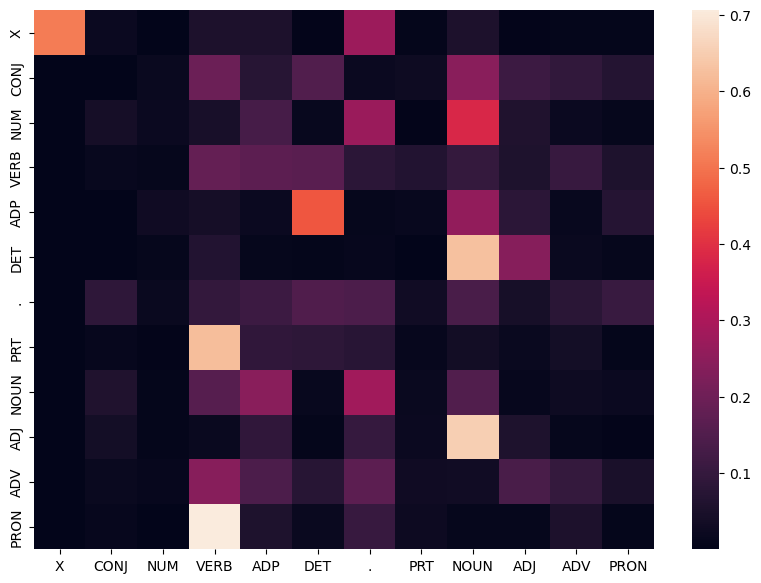

In [31]:
# heatmap of transition probabilities

plt.figure(figsize = (10, 7))
seaborn.heatmap(pandas.DataFrame(tag_transition_matrix, columns = unique_taglist, index = unique_taglist))
plt.show()

In [32]:
# creating a dictionary to easily access the indices of each tag in the matrix

tag_indices = {tag : idx for idx, tag in enumerate(unique_taglist)}
print(tag_indices)

{'X': 0, 'CONJ': 1, 'NUM': 2, 'VERB': 3, 'ADP': 4, 'DET': 5, '.': 6, 'PRT': 7, 'NOUN': 8, 'ADJ': 9, 'ADV': 10, 'PRON': 11}


In [33]:
# viterbi algorithm to find best fitting tag sequence

def viterbi(input_sentence):

    # specifying dimensions

    sentence_length = len(input_sentence)
    tags_length = len(unique_taglist)
    
    # initializing state_probabilities to store probabilities per word

    state_probabilities = torch.zeros(sentence_length, tags_length)
    max_states = torch.zeros(sentence_length, dtype = int)

    # calculate tag probabilites per word
    
    for idx, word in enumerate(input_sentence):
        
        # specifying the index of the previous most likely tag/state

        if idx == 0:
            prev_tag_idx = tag_indices['.']
        else:
            prev_tag_idx = torch.argmax(state_probabilities[idx - 1])
        
        for tag_idx, tag in enumerate(unique_taglist):

            # calculating state probabilities and filling up the tensor

            transition_prob = tag_transition_matrix[prev_tag_idx][tag_idx]
            state_probabilities[idx][tag_idx] = transition_prob * ep_word_tag(word, tag)

        print(f"{idx + 1} / {sentence_length}", end = "\r")

    # evaluating the highest probability tag index per word
    
    max_states = torch.argmax(state_probabilities, dim=1)
    state = [unique_taglist[idx] for idx in max_states]
    
    return zip(input_sentence, state)


In [34]:
# listing the testing tags and words in order

test_taglist = [tag for word, tag in testing_words_tagged]
test_wordlist = [word for word, tag in testing_words_tagged]

In [35]:
# feeding the testing wordlist into viterbi, treating it as a large sentence
# this took a really long time to run for a larger test set, so i made it relatively a lot smaller

prediction_dict = viterbi(test_wordlist)

# listing the predicted tags in order

predicted_tags = [tag for word, tag in prediction_dict]

In [36]:
# lengths of the wordlist, true taglist, and predicted taglist; they should all be equal

print(len(test_wordlist))
print(len(test_taglist))
print(len(predicted_tags))

11147
11147
11147


In [37]:
# converting to a dataframe

data = {"words" : test_wordlist, "true_tags" : test_taglist, "predicted_tags" : predicted_tags}

test_df = pandas.DataFrame(data)
test_df

,words,true_tags,predicted_tags
0,Open,ADJ,NOUN
1,market,NOUN,NOUN
2,policy,NOUN,NOUN
3,And,CONJ,CONJ
4,you,PRON,PRON
...,...,...,...
11142,left,VERB,VERB
11143,a,DET,DET
11144,few,ADJ,ADJ
11145,things,NOUN,NOUN


In [38]:
# evaluating accuracy

sklearn.metrics.accuracy_score(test_df['true_tags'], test_df['predicted_tags'])

0.9415089261684758